In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Default title text
## Download Input dataset for analytics
# https://propensity-labs-screening.s3.amazonaws.com/analytics/analytics_input.csv

In [ ]:
#Create Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CSV Download").getOrCreate()

In [ ]:
#Read CSV to Dataframe
df = spark.read.csv("sample_data/analytics_input.csv",header=True, inferSchema=True)

In [ ]:
#Display Scheme
df.printSchema()

root
 |-- DRG Definition: string (nullable = true)
 |-- Provider Id: string (nullable = true)
 |-- Provider Name: string (nullable = true)
 |-- Provider Street Address: string (nullable = true)
 |-- Provider City: string (nullable = true)
 |-- Provider State: string (nullable = true)
 |-- Provider Zip Code: integer (nullable = true)
 |-- Hospital Referral Region Description: string (nullable = true)
 |--  Total Discharges : integer (nullable = true)
 |--  Average Covered Charges : string (nullable = true)
 |--  Average Total Payments : string (nullable = true)
 |-- Average Medicare Payments: string (nullable = true)



In [ ]:
#Change Column names to remove spaces, lower case and replace spaces in column names with "_" (underscore)

df_new = df.toDF(*(c.lower().strip().replace(' ', '_') for c in df.columns))
df_new.printSchema()
df_new.head(10)

root
 |-- drg_definition: string (nullable = true)
 |-- provider_id: string (nullable = true)
 |-- provider_name: string (nullable = true)
 |-- provider_street_address: string (nullable = true)
 |-- provider_city: string (nullable = true)
 |-- provider_state: string (nullable = true)
 |-- provider_zip_code: integer (nullable = true)
 |-- hospital_referral_region_description: string (nullable = true)
 |-- total_discharges: integer (nullable = true)
 |-- average_covered_charges: string (nullable = true)
 |-- average_total_payments: string (nullable = true)
 |-- average_medicare_payments: string (nullable = true)



[Row(drg_definition='039 - EXTRACRANIAL PROCEDURES W/O CC/MCC', provider_id='10001', provider_name='SOUTHEAST ALABAMA MEDICAL CENTER', provider_street_address='1108 ROSS CLARK CIRCLE', provider_city='DOTHAN', provider_state='AL', provider_zip_code=36301, hospital_referral_region_description='AL - Dothan', total_discharges=91, average_covered_charges='$32963.07', average_total_payments='$5777.24', average_medicare_payments='$4763.73'),
 Row(drg_definition='039 - EXTRACRANIAL PROCEDURES W/O CC/MCC', provider_id='10005', provider_name='MARSHALL MEDICAL CENTER SOUTH', provider_street_address='2505 U S HIGHWAY 431 NORTH', provider_city='BOAZ', provider_state='AL', provider_zip_code=35957, hospital_referral_region_description='AL - Birmingham', total_discharges=14, average_covered_charges='$15131.85', average_total_payments='$5787.57', average_medicare_payments='$4976.71'),
 Row(drg_definition='039 - EXTRACRANIAL PROCEDURES W/O CC/MCC', provider_id='10006', provider_name='ELIZA COFFEE MEMORI

In [ ]:
from pyspark.sql.functions import col
#Identify all rows with Null values for provider id
null_provider_id_df = df_new.filter(col("provider_id").isNull())
null_provider_id_df.show()

+--------------+-----------+-------------+-----------------------+-------------+--------------+-----------------+------------------------------------+----------------+-----------------------+----------------------+-------------------------+
|drg_definition|provider_id|provider_name|provider_street_address|provider_city|provider_state|provider_zip_code|hospital_referral_region_description|total_discharges|average_covered_charges|average_total_payments|average_medicare_payments|
+--------------+-----------+-------------+-----------------------+-------------+--------------+-----------------+------------------------------------+----------------+-----------------------+----------------------+-------------------------+
+--------------+-----------+-------------+-----------------------+-------------+--------------+-----------------+------------------------------------+----------------+-----------------------+----------------------+-------------------------+



In [ ]:
#Change fields with Payment information into numbers by using Lambda functions in python
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# define a lambda function to convert payment information to numeric format
to_numeric = lambda col: float(col.replace("$", ""))

# apply the lambda function to the payment fields
df_new = df_new.withColumn("average_total_payments", udf(to_numeric)('average_total_payments')).withColumn("average_covered_charges", udf(to_numeric)('average_covered_charges')).withColumn("average_medicare_payments", udf(to_numeric)('average_medicare_payments'))

# show the resulting dataframe
df_new.show()





+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+----------------+-----------------------+----------------------+-------------------------+
|      drg_definition|provider_id|       provider_name|provider_street_address|provider_city|provider_state|provider_zip_code|hospital_referral_region_description|total_discharges|average_covered_charges|average_total_payments|average_medicare_payments|
+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+----------------+-----------------------+----------------------+-------------------------+
|039 - EXTRACRANIA...|      10001|SOUTHEAST ALABAMA...|   1108 ROSS CLARK C...|       DOTHAN|            AL|            36301|                         AL - Dothan|              91|               32963.07|               5777.24|           

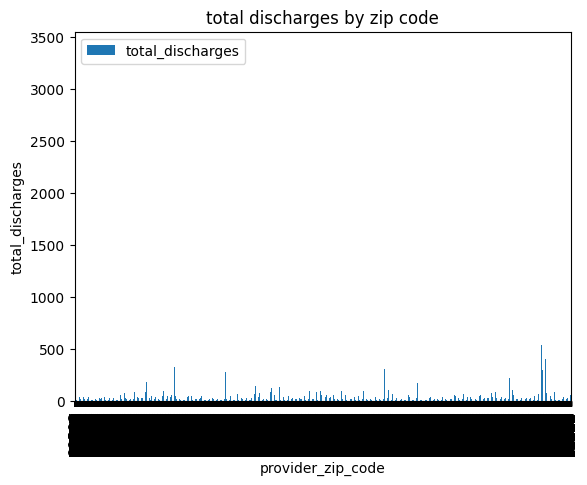

In [ ]:
#Plot a Bar chart by state and "Average Total Payments" and zip code vs "total_charges"
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

# convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = df_new.toPandas()

# create the bar chart
pandas_df.plot(kind='bar', x='provider_zip_code', y='total_discharges')
plt.xlabel("provider_zip_code")
plt.ylabel("total_discharges")
plt.title("total discharges by zip code")
plt.show()




In [ ]:
#BONUS - Plot intersting statistics from the dataset

In [ ]:
#Write the Dataset to a Parquet format partitioned by State
df_new.write.mode("overwrite").partitionBy("provider_state").parquet("sample_data/parquet/")
df_read = spark.read.parquet("sample_data/parquet/")

# show the resulting dataframe
df_read.show()

+--------------------+-----------+--------------------+-----------------------+-------------+-----------------+------------------------------------+----------------+-----------------------+----------------------+-------------------------+--------------+
|      drg_definition|provider_id|       provider_name|provider_street_address|provider_city|provider_zip_code|hospital_referral_region_description|total_discharges|average_covered_charges|average_total_payments|average_medicare_payments|provider_state|
+--------------------+-----------+--------------------+-----------------------+-------------+-----------------+------------------------------------+----------------+-----------------------+----------------------+-------------------------+--------------+
|039 - EXTRACRANIA...|      50006|  ST JOSEPH HOSPITAL|        2700 DOLBEER ST|       EUREKA|            95501|                        CA - Redding|              48|               44664.45|               8227.14|                  6936.52|